<div style="display: flex; flex-direction: column; align-items: center; text-align: center; font-family: 'Avenir Next LT Pro', sans-serif; padding: 50px; background-color: #f4f4f4; border-radius: 12px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.1);">
    <h1 style="font-size: 50px; font-weight: bold; color: #222; margin-bottom: 10px;">Filologia Digital - Módulo V</h1>
    <h3 style="font-size: 30px; font-weight: bold; color: #555; max-width: 80%; line-height: 1.3;">
        Para além da edição: <span style="font-weight: normal; color: #666;">o digital na investigação linguística</span>
    </h3>
    <h4 style="font-size: 26px; font-weight: bold; color: #333; background-color: #e0e0e0; padding: 10px 20px; border-radius: 8px; margin-top: 25px;">Sessão 5 - Data Preparation</h4>
    <img src="https://filologiadigitalcl.wordpress.com/wp-content/uploads/2024/11/figure05.png?w=1024" 
         style="width: 80%; max-width: 600px; margin-top: 30px; border-radius: 10px; box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.15);">
</div>

<a class='anchor' id='1'></a>

# **1. Setup projeto** 

#### Imports

In [ ]:
import re
import nltk
import emoji
import unidecode
import pandas as pd
import numpy as np
from tqdm import tqdm
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer, PorterStemmer
from nltk.tokenize import TweetTokenizer, TreebankWordTokenizer
from nltk import pos_tag
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer

# Caminho da pasta "root"
base_dir = Path(os.getcwd()).resolve()  # Ajuste se necessário, podes utilizar .parent para subir um nível
data_dir = base_dir / "Data"  # Diretório onde os dados serão armazenados
base_dir


WindowsPath('C:/Users/diogo/Desktop/Filologia_Digital-Modulo_V/Session4')

In [77]:
!pip install emoji unidecode unidecode textblob scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Leitura dos dados

In [39]:
df_train, df_test = pd.read_csv(data_dir / "Tweets_EN_sentiment_train.csv"), pd.read_csv(data_dir / "Tweets_EN_sentiment_test.csv")
del df_train['tweet']  # Remove a coluna 'tweet' do DataFrame de treino
del df_test['tweet']  # Remove a coluna 'tweet' do DataFrame de teste
df_train

,text,class
0,"some count sheep, you count cats",pos
1,We haven't been to Turning Stone in ages! Have...,pos
2,What up,pos
3,I'm good,pos
4,"I know, wonder if USER is going to buy an apar...",pos
...,...,...
39931,"LOL- F, please",pos
39932,I wish I could do that too! But it ain't happe...,neg
39933,I &lt;3 my boyfriend's family.,pos
39934,404,neg


In [40]:
# Existem nulos no nosso dataset, é preciso eliminá-los
df_train.isna().sum()

text     235
class      0
dtype: int64

In [41]:
df_train = df_train.dropna(subset=['text'])
df_test = df_test.dropna(subset=['text'])
df_train

,text,class
0,"some count sheep, you count cats",pos
1,We haven't been to Turning Stone in ages! Have...,pos
2,What up,pos
3,I'm good,pos
4,"I know, wonder if USER is going to buy an apar...",pos
...,...,...
39931,"LOL- F, please",pos
39932,I wish I could do that too! But it ain't happe...,neg
39933,I &lt;3 my boyfriend's family.,pos
39934,404,neg


# 2. **Passos para um pré-processamento mais avançado**

## 2.1. **Remover Elementos Dispersos e Distratores (Remoções Diretas)**
**Objetivo**: Eliminar elementos que não acrescentam valor semântico ou que introduzem ruído nos dados.

### 2.1.1. **Remover emojis**
**Justificação**: Emojis são visuais, não verbais — não são úteis para modelos baseados apenas em texto.

In [42]:
# Exemplo de Texto
exemplo = "I love this movie! 😂🔥 #bestmovieever :D"
emoji.replace_emoji(exemplo, replace='')

'I love this movie!  #bestmovieever :D'

In [43]:
import re
import emoji

exemplo = "I love this movie! 😂🔥 #bestmovieever :D"

def remover_emojis_e_emoticons(texto):
    # Primeiro removemos os emojis reais
    sem_emojis = emoji.replace_emoji(texto, replace='')
    
    # Agora removemos emoticons do tipo ':D', ':)', etc.
    sem_emoticons = re.sub(r'(:\)|:\(|:D|:P|;-?\)|:-?\(|:O|:\||:3|:\'\(|:\/|:s|xD)', '', sem_emojis, flags=re.IGNORECASE)
    
    return sem_emoticons.strip()

remover_emojis_e_emoticons(exemplo)

'I love this movie!  #bestmovieever'

In [44]:
df_train.loc[:, 'clean_text_emojis'] = df_train['text'].apply(remover_emojis_e_emoticons)
df_train[df_train['text'].str.contains(':D', case=False, na=False, regex=False)]  # No ficheiro Data_understanding.ipynb, verificamos que existem emoticons do tipo ':D' no dataset

C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\2034591694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'clean_text_emojis'] = df_train['text'].apply(remover_emojis_e_emoticons)


,text,class,clean_text_emojis
872,I am working on sunday... but we should catch...,neg,I am working on sunday... but we should catch...
991,woke up at 9.30 am (!?!?!) and now is making s...,pos,woke up at 9.30 am (!?!?!) and now is making s...
1244,When in August. I have travel plans that month...,pos,When in August. I have travel plans that month...
1410,haha i so want to go with who ever wants to go...,neg,haha i so want to go with who ever wants to go...
1450,so you are able to light up many eyes and hea...,pos,so you are able to light up many eyes and hear...
...,...,...,...
38872,bakkk learned CHORDS :D got some guitar picks ...,pos,bakkk learned CHORDS got some guitar picks an...
38998,are you hungry too? :D,pos,are you hungry too?
39191,hello to you too! there is no such thing as sl...,pos,hello to you too! there is no such thing as sl...
39207,YAY! i got a Wii!! :D lol and i also got Need ...,pos,YAY! i got a Wii!! lol and i also got Need fo...


C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\2068463537.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['len_original'] = df_train.loc[:,'text'].apply(len)
C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\2068463537.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['len_no_emojis'] = df_train.loc[:,'clean_text_emojis'].apply(len)


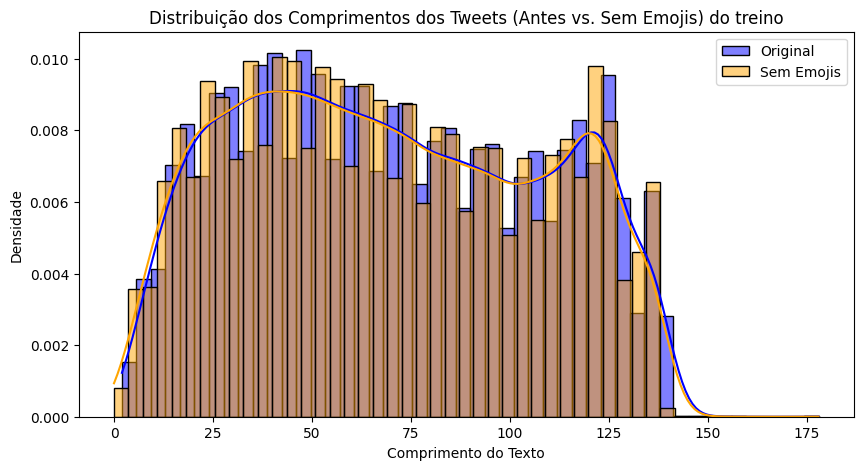

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

df_train['len_original'] = df_train.loc[:,'text'].apply(len)
df_train['len_no_emojis'] = df_train.loc[:,'clean_text_emojis'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(df_train.loc[:,'len_original'], color='blue', label='Original', kde=True, stat='density')
sns.histplot(df_train.loc[:,'len_no_emojis'], color='orange', label='Sem Emojis', kde=True, stat='density')
plt.title("Distribuição dos Comprimentos dos Tweets (Antes vs. Sem Emojis) do treino")
plt.xlabel("Comprimento do Texto")
plt.ylabel("Densidade")
plt.legend()
plt.show()

del df_train['len_original'], df_train['len_no_emojis'], df_train['clean_text_emojis']  # Limpa as colunas temporárias após a visualização

**Conclusão**: Remover
- **Justificação**: Apesar dos emojis transmitirem emoção, são difíceis de interpretar de forma consistente por algoritmos simples. Optámos por removê-los para evitar ambiguidade.

### 2.1.2. **Remover URLs**
**Justificação**: URLs são frequentemente irrelevantes para análise de sentimento textual e podem ser ruído nos dados.

In [46]:
# Exemplo de Texto
exemplo = "Check this out http://example.com, it's awesome!"

def remover_urls(texto):
    return re.sub(r'http\S+|www\S+|https\S+|URL', '', texto, flags=re.MULTILINE)

remover_urls(exemplo)

"Check this out  it's awesome!"

In [47]:
df_train['clean_text_no_urls'] = df_train['text'].fillna('').apply(remover_urls)
df_train[df_train['text'].str.contains('http', case=False, na=False, regex=False)]  # No ficheiro Data_understanding.ipynb, verificamos que existem emoticons do tipo ':D' no dataset

C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\1026122177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['clean_text_no_urls'] = df_train['text'].fillna('').apply(remover_urls)


,text,class,clean_text_no_urls
4135,Just put the http:// in front of your web addr...,pos,Just put the in front of your web address
4228,Only a few more hours left for Cans For Commen...,pos,Only a few more hours left for Cans For Commen...
4751,Just finished completing my http:/boxee.tv USE...,pos,Just finished completing my USER profile. W...
8970,"I m dying with CGI , need to set up for Mercur...",neg,"I m dying with CGI , need to set up for Mercur..."
16018,Good job Mark! btw too many 't's in your http ...,pos,Good job Mark! btw too many 't's in your http ...
18153,its 4 AM and i'm still wondering whats wrong w...,neg,its 4 AM and i'm still wondering whats wrong w...
23801,did you get better speed? i think the curb li...,neg,did you get better speed? i think the curb li...
33445,on my home laptop http downloads are happening...,neg,on my home laptop http downloads are happening...
39144,Tiredddd wanna go homee... Or I should have s...,neg,Tiredddd wanna go homee... Or I should have s...


C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\1283173264.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['len_original'] = df_train['text'].fillna('').apply(len)
C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\1283173264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['len_no_urls'] = df_train['clean_text_no_urls'].fillna('').apply(len)


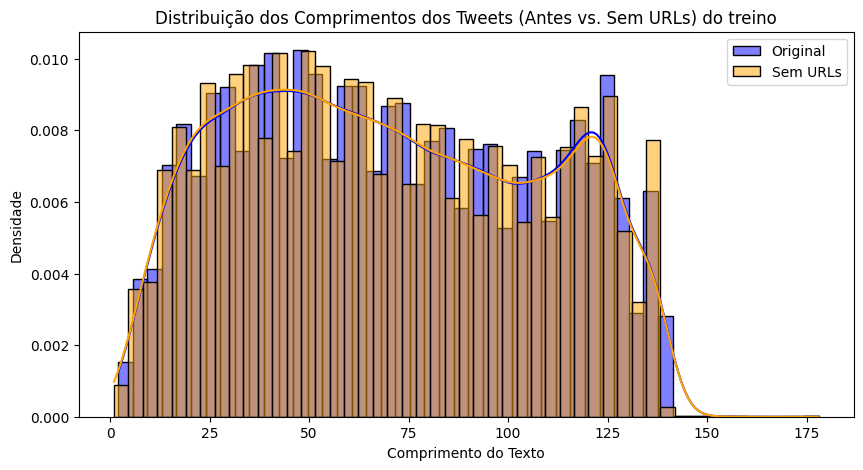

In [48]:
df_train['len_original'] = df_train['text'].fillna('').apply(len)
df_train['len_no_urls'] = df_train['clean_text_no_urls'].fillna('').apply(len)

plt.figure(figsize=(10,5))
sns.histplot(df_train['len_original'], color='blue', label='Original', kde=True, stat='density')
sns.histplot(df_train['len_no_urls'], color='orange', label='Sem URLs', kde=True, stat='density')
plt.title("Distribuição dos Comprimentos dos Tweets (Antes vs. Sem URLs) do treino")
plt.xlabel("Comprimento do Texto")
plt.ylabel("Densidade")
plt.legend()
plt.show()

del df_train['len_original'], df_train['len_no_urls'], df_train['clean_text_no_urls']  # Limpa as colunas temporárias após a visualização

**Conclusão**: Manter
- **Justificação**: URLs podem conter conteúdo informativo importante, logo optou-se por mantê-las.

### 2.1.3. **Remover Hashtags (apenas o símbolo #)**
**Justificação**: O símbolo ``#`` é ruído visual, mas a palavra da hashtag pode conter informação útil.

In [49]:
exemplo = "Loving the weather! #sunnyday #happy"
def remover_hashtags(texto):
    return re.sub(r'#', '', texto)

print(remover_hashtags(exemplo))

Loving the weather! sunnyday happy


In [50]:
df_train['clean_no_hashtags'] = df_train['text'].fillna('').apply(remover_hashtags)
df_train[df_train['text'].str.contains('#', case=False, na=False, regex=False)]  # Verifica se existem hashtags no dataset

C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\1338577047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['clean_no_hashtags'] = df_train['text'].fillna('').apply(remover_hashtags)


,text,class,clean_no_hashtags
186,#overbooked flight...the reason is easy. Ghos...,pos,overbooked flight...the reason is easy. Ghosts.
259,If anyone out there wants to know more about #...,pos,If anyone out there wants to know more about A...
300,RETWEET Check out #ActionsTalk #22 featuring C...,pos,RETWEET Check out ActionsTalk 22 featuring Cd ...
318,I nominate USER for a Shorty Award in #tech be...,pos,I nominate USER for a Shorty Award in tech bec...
510,You're a quick draw. Your USER #13 beat my #2 ...,pos,You're a quick draw. Your USER 13 beat my 2 by...
...,...,...,...
39642,#flylady Did some WiiFit w/ DKs Family Fun Mov...,pos,flylady Did some WiiFit w/ DKs Family Fun Move...
39725,#flylady Today is day 3 of quitting smoking an...,pos,flylady Today is day 3 of quitting smoking and...
39851,My Page Rank according to Google. It's a very...,pos,My Page Rank according to Google. It's a very...
39871,"Re: Yahoo slide #12: Don't ""own""...""PWN the e...",neg,"Re: Yahoo slide 12: Don't ""own""...""PWN the em..."


C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\2158054512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['len_original'] = df_train['text'].fillna('').apply(len)
C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\2158054512.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['len_no_hashtags'] = df_train['clean_no_hashtags'].apply(len)


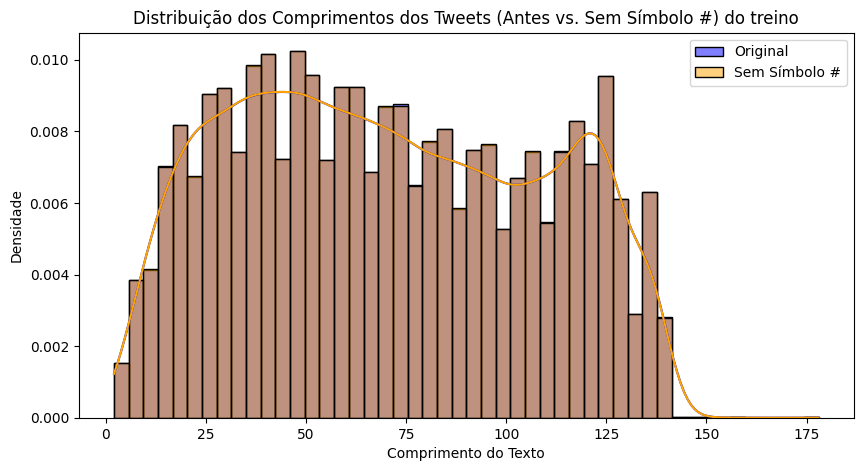

In [51]:
df_train['len_original'] = df_train['text'].fillna('').apply(len)
df_train['len_no_hashtags'] = df_train['clean_no_hashtags'].apply(len)

plt.figure(figsize=(10,5))
sns.histplot(df_train['len_original'], color='blue', label='Original', kde=True, stat='density')
sns.histplot(df_train['len_no_hashtags'], color='orange', label='Sem Símbolo #', kde=True, stat='density')
plt.title("Distribuição dos Comprimentos dos Tweets (Antes vs. Sem Símbolo #) do treino")
plt.xlabel("Comprimento do Texto")
plt.ylabel("Densidade")
plt.legend()
plt.show()

del df_train['len_original'], df_train['len_no_hashtags'], df_train['clean_no_hashtags']  # Limpa as colunas temporárias após a visualização

### 2.1.4. **Remover Números**
**Justificação**: Números isolados em tweets geralmente não têm contexto útil.

In [52]:
exemplo = "I ran 10 km today and it took 1 hour"

def remover_numeros(texto):
    return re.sub(r'\d+', '', texto)

print(remover_numeros(exemplo))

I ran  km today and it took  hour


In [53]:
df_train['clean_no_numbers'] = df_train['text'].fillna('').apply(remover_numeros)
df_train[df_train['text'].str.contains('#', case=False, na=False)]

C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\4029694848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['clean_no_numbers'] = df_train['text'].fillna('').apply(remover_numeros)


,text,class,clean_no_numbers
186,#overbooked flight...the reason is easy. Ghos...,pos,#overbooked flight...the reason is easy. Ghos...
259,If anyone out there wants to know more about #...,pos,If anyone out there wants to know more about #...
300,RETWEET Check out #ActionsTalk #22 featuring C...,pos,RETWEET Check out #ActionsTalk # featuring Cd ...
318,I nominate USER for a Shorty Award in #tech be...,pos,I nominate USER for a Shorty Award in #tech be...
510,You're a quick draw. Your USER #13 beat my #2 ...,pos,You're a quick draw. Your USER # beat my # by ...
...,...,...,...
39642,#flylady Did some WiiFit w/ DKs Family Fun Mov...,pos,#flylady Did some WiiFit w/ DKs Family Fun Mov...
39725,#flylady Today is day 3 of quitting smoking an...,pos,#flylady Today is day of quitting smoking and...
39851,My Page Rank according to Google. It's a very...,pos,My Page Rank according to Google. It's a very...
39871,"Re: Yahoo slide #12: Don't ""own""...""PWN the e...",neg,"Re: Yahoo slide #: Don't ""own""...""PWN the emp..."


C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\3557074970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['len_original'] = df_train['text'].fillna('').apply(len)
C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\3557074970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['len_no_numbers'] = df_train['clean_no_numbers'].apply(len)


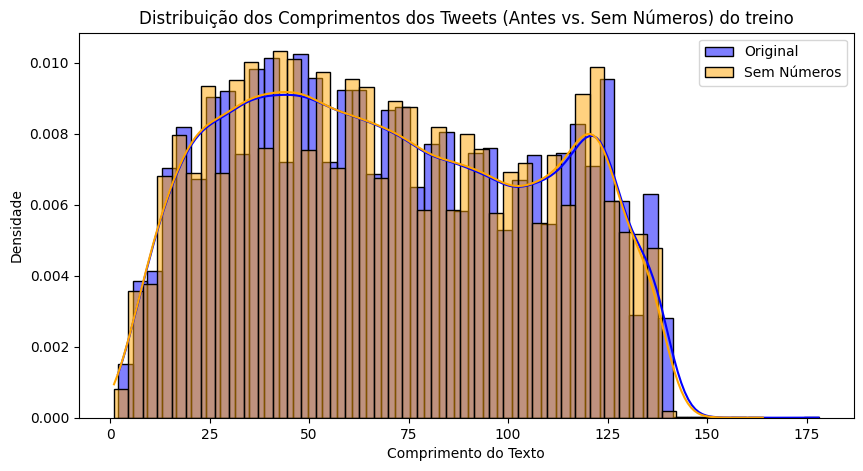

In [54]:
df_train['len_original'] = df_train['text'].fillna('').apply(len)
df_train['len_no_numbers'] = df_train['clean_no_numbers'].apply(len)

plt.figure(figsize=(10,5))
sns.histplot(df_train['len_original'], color='blue', label='Original', kde=True, stat='density')
sns.histplot(df_train['len_no_numbers'], color='orange', label='Sem Números', kde=True, stat='density')
plt.title("Distribuição dos Comprimentos dos Tweets (Antes vs. Sem Números) do treino")
plt.xlabel("Comprimento do Texto")
plt.ylabel("Densidade")
plt.legend()
plt.show()

del df_train['len_original'], df_train['len_no_numbers'], df_train['clean_no_numbers']  # Limpa as colunas temporárias após a visualização

**Conclusão**: Remover
- **Justificação**: Removemos números para evitar ruído, já que sozinhos raramente trazem significado útil.

## 2.2. **Alterar Texto (Transformações de Forma)**

### 2.2.1. **Lower Case**
- **Justificação**: A capitalização pode indicar tom emocional ou ironia. Por exemplo, "I LOVE this" transmite mais entusiasmo que "I love this".

In [55]:
# Exemplo de Texto
exemplo = "I LOVE this movie, it's AMAZING!"

# Normalmente faríamos:
exemplo.lower()
# Mas neste caso optamos por NÃO aplicar .lower()

"i love this movie, it's amazing!"

**Decisão**: ❌ Não aplicamos lowercase.

### 2.2.2. **Stemming**
- **Justificação**: O stemming reduz palavras à sua raiz, o que pode distorcer a linguagem informal dos tweets. Exemplo: "happiness" → "happi", "loved" → "love", o que pode levar à perda de nuances.

In [56]:
# Exemplo de Stemming com PorterStemmer
from nltk.stem import PorterStemmer
ps = PorterStemmer()
palavras = ["happiness", "loved", "running"]
[ps.stem(p) for p in palavras]
# Resultado: ['happi', 'love', 'run']

['happi', 'love', 'run']

In [57]:
df_train["clean_text_stemmed"] = df_train["text"].fillna('').apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
df_train

C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\62219340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["clean_text_stemmed"] = df_train["text"].fillna('').apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))


,text,class,clean_text_stemmed
0,"some count sheep, you count cats",pos,"some count sheep, you count cat"
1,We haven't been to Turning Stone in ages! Have...,pos,we haven't been to turn stone in ages! have a ...
2,What up,pos,what up
3,I'm good,pos,i'm good
4,"I know, wonder if USER is going to buy an apar...",pos,"i know, wonder if user is go to buy an apart a..."
...,...,...,...
39931,"LOL- F, please",pos,"lol- f, pleas"
39932,I wish I could do that too! But it ain't happe...,neg,i wish i could do that too! but it ain't happen
39933,I &lt;3 my boyfriend's family.,pos,i &lt;3 my boyfriend' family.
39934,404,neg,404


In [58]:
del df_train["clean_text_stemmed"]  # Limpa a coluna temporária após a visualização

**Decisão**: ❌ Não aplicamos stemming, para preservar a forma original das palavras.

### 2.2.3. **POS tagging + lematização**
- **Justificação**: Apesar da lematização ajudar a normalizar palavras (ex: "am", "are", "is" → "be"), a combinação com POS tagging torna o processamento mais pesado e, neste caso, não trouxe melhoria clara no desempenho.

In [59]:
# Exemplo com lematização + POS
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

texto = "Cats are running and playing happily"

def lematizar_com_pos(texto):
    if not isinstance(texto, str):
        return ""
    tokens = word_tokenize(texto)
    pos_tags = pos_tag(tokens)
    print(pos_tags) # Exibe as tags POS, cuidado que pode ser uma lista grande
    lemmatizer = WordNetLemmatizer()
    lematizado = [lemmatizer.lemmatize(palavra, get_wordnet_pos(tag)) for palavra, tag in pos_tags]
    return " ".join(lematizado)

lematizar_com_pos(texto)

[('Cats', 'NNS'), ('are', 'VBP'), ('running', 'VBG'), ('and', 'CC'), ('playing', 'VBG'), ('happily', 'RB')]


'Cats be run and play happily'

**Tags de Part-of-Speech (POS) do NLTK**

| Tag  | Significado                     | Exemplo(s)                     |
|------|---------------------------------|--------------------------------|
| CC   | Coordinating conjunction        | and, or, but                   |
| CD   | Cardinal number                 | 1, 2, three                    |
| DT   | Determiner                      | the, a, some                   |
| EX   | Existential there               | "there" in "there is"          |
| FW   | Foreign word                    | d'accord, habeas               |
| IN   | Preposition/subord. conjunction | in, of, like, because         |
| JJ   | Adjective                       | happy, blue                    |
| JJR  | Adjective, comparative          | happier, bluer                 |
| JJS  | Adjective, superlative          | happiest, bluest               |
| LS   | List marker                     | 1), 2), *                      |
| MD   | Modal verb                      | can, should, will              |
| NN   | Noun, singular                  | cat, table                     |
| NNS  | Noun, plural                    | cats, tables                   |
| NNP  | Proper noun, singular           | John, London                   |
| NNPS | Proper noun, plural             | Vikings, Americans             |
| PDT  | Predeterminer                   | all, both                      |
| POS  | Possessive ending               | 's                             |
| PRP  | Personal pronoun                | I, you, he                     |
| PRP$ | Possessive pronoun              | my, your, his                  |
| RB   | Adverb                          | quickly, never                 |
| RBR  | Adverb, comparative             | faster                         |
| RBS  | Adverb, superlative             | fastest                        |
| RP   | Particle                        | up, off                        |
| SYM  | Symbol                          | $, %, &                        |
| TO   | "to"                            | to                             |
| UH   | Interjection                    | oh, hello                      |
| VB   | Verb, base form                 | run, eat                       |
| VBD  | Verb, past tense                | ran, ate                       |
| VBG  | Verb, gerund/present participle | running, eating                |
| VBN  | Verb, past participle           | run, eaten                     |
| VBP  | Verb, non-3rd person singular   | run, eat                       |
| VBZ  | Verb, 3rd person singular       | runs, eats                     |
| WDT  | Wh-determiner                   | which, that                    |
| WP   | Wh-pronoun                      | who, what                      |
| WP$  | Possessive wh-pronoun           | whose                          |
| WRB  | Wh-adverb                       | where, when                    |

**Decisão**: ❌ Não aplicamos POS tagging + lematização.

### 2.2.4. **Tratamento de negações**
- **Justificação**: As negações podem inverter o significado. Exemplo: "not good" → "NEG_good", o que preserva a negação durante o treino do modelo.

In [60]:
# Exemplo
from nltk.tokenize import word_tokenize

def tratar_negacoes(texto):
    tokens = word_tokenize(texto)
    output = []
    negacao = False
    negadores = {"not", "no", "n't"}

    for token in tokens:
        if token.lower() in negadores:
            negacao = True
            output.append(token)
        elif negacao:
            output.append("NEG_" + token)
            negacao = False
        else:
            output.append(token)
    return ' '.join(output)

exemplo = "This movie is not good but not terrible"
tratar_negacoes(exemplo)
# Resultado: 'This movie is not NEG_good but not NEG_terrible'

'This movie is not NEG_good but not NEG_terrible'

In [61]:
df_train['clean_text_neg'] = df_train['text'].apply(tratar_negacoes)
df_train[df_train['clean_text_neg'].str.contains('NEG_', case=False, na=False, regex=False)]  # Verifica se existem negações no dataset

C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\2239651795.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['clean_text_neg'] = df_train['text'].apply(tratar_negacoes)


,text,class,clean_text_neg
1,We haven't been to Turning Stone in ages! Have...,pos,We have n't NEG_been to Turning Stone in ages ...
6,USER Facebook is down. It's not you guys,pos,USER Facebook is down . It 's not NEG_you guys
10,I have to agree with USER Design...I have Vist...,pos,I have to agree with USER Design ... I have Vi...
14,my husband has a deep and irrational fear of c...,neg,my husband has a deep and irrational fear of c...
15,No... just heard abt it... still my product us...,neg,No NEG_... just heard abt it ... still my prod...
...,...,...,...
39892,"yes automatic dm is outrageous, i don't need s...",pos,"yes automatic dm is outrageous , i do n't NEG_..."
39907,"asi neni... no, udanicko jsem jeste nepsal",pos,"asi neni ... no NEG_, udanicko jsem jeste nepsal"
39919,I'm not well,neg,I 'm not NEG_well
39926,I like it. Just not tonight.,pos,I like it . Just not NEG_tonight .


In [62]:
del df_train["clean_text_neg"]  # Limpa a coluna temporária após a visualização

## 2.3. **Tokenização**
- Comparação de tokenizadores — por que o TweetTokenizer é o mais adequado para dados do Twitter.

In [63]:
exemplo = "Sooooo happy @user!!! 😂😂 Check this out: https://link.com #amazing #LOVEit :D"

from nltk.tokenize import word_tokenize, TreebankWordTokenizer, TweetTokenizer

print(f"Word Tokenization: {word_tokenize(exemplo)}")
print(f"Treebank Word Tokenization: {TreebankWordTokenizer().tokenize(exemplo)}")
print(f"Tweet Tokenization: {TweetTokenizer().tokenize(exemplo)}")

Word Tokenization: ['Sooooo', 'happy', '@', 'user', '!', '!', '!', '😂😂', 'Check', 'this', 'out', ':', 'https', ':', '//link.com', '#', 'amazing', '#', 'LOVEit', ':', 'D']
Treebank Word Tokenization: ['Sooooo', 'happy', '@', 'user', '!', '!', '!', '😂😂', 'Check', 'this', 'out', ':', 'https', ':', '//link.com', '#', 'amazing', '#', 'LOVEit', ':', 'D']
Tweet Tokenization: ['Sooooo', 'happy', '@user', '!', '!', '!', '😂', '😂', 'Check', 'this', 'out', ':', 'https://link.com', '#amazing', '#LOVEit', ':D']


C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\719405618.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_tok, x='Tokenizador', y='Nº de Tokens', palette='pastel')


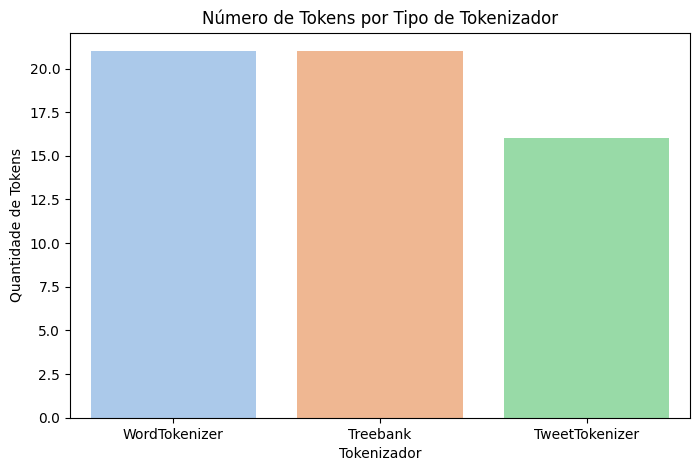

In [64]:
tokens_dict = {
    'WordTokenizer': word_tokenize(exemplo),
    'Treebank': TreebankWordTokenizer().tokenize(exemplo),
    'TweetTokenizer': TweetTokenizer().tokenize(exemplo)
}

import pandas as pd
import matplotlib.pyplot as plt

df_tok = pd.DataFrame({
    'Tokenizador': list(tokens_dict.keys()),
    'Nº de Tokens': [len(tokens) for tokens in tokens_dict.values()]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=df_tok, x='Tokenizador', y='Nº de Tokens', palette='pastel')
plt.title('Número de Tokens por Tipo de Tokenizador')
plt.ylabel('Quantidade de Tokens')
plt.xlabel('Tokenizador')
plt.show()


| Tokenizador         | Lida com Emojis | Hashtags | Menções | Redução de repetições | Emoticons |
| ------------------- | --------------- | -------- | ------- | --------------------- | --------- |
| `word_tokenize`     | ❌               | ❌        | ❌       | ❌                     | ❌         |
| `TreebankTokenizer` | ❌               | ✅        | ✅       | ❌                     | ❌         |
| ✅ `TweetTokenizer`  | ✅               | ✅        | ✅       | ✅                     | ✅         |


## 2.4. Remoção de Stopwords com negações preservadas
- **Subtítulo:** Eliminar palavras comuns irrelevantes, mantendo as negações (ex: “not”, “no”), que são cruciais para o sentido.

✅ Justificação
- Stopwords são palavras muito frequentes que geralmente não carregam informação semântica forte, como "the", "is", "at", etc.
- Contudo, palavras de negação como “not”, “no”, “never” devem ser preservadas, pois mudam completamente o significado de uma frase:
    - “I am happy” vs “I am not happy”



In [65]:
exemplo = "I do not like this movie at all. It is really bad and boring."

In [66]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# Stopwords padrão
stop_words = set(stopwords.words('english'))
'no' in stop_words  # Ele considera 'no' como stopword

True

In [67]:
# Remover negações da lista de stopwords
negacoes = {
    'no', 'not', 'never', 'none', 'nobody', 'nothing', 'neither', 'nowhere',
    "n't", "cannot", "can't", "dont", "don't", "doesn't", "isn't", "wasn't",
    "aren't", "hasn't", "haven't", "hadn't", "won't", "wouldn't", "shouldn't",
    "couldn't", "mightn't", "mustn't", "shan't", "without", "barely", 
    "hardly", "scarcely", "rarely", "seldom", "nor", "ain't"
}

stop_words_sem_negacoes = stop_words - negacoes

# Inicializar tokenizador
tokenizer = TweetTokenizer()

def remover_stopwords_preservando_negacoes(texto):
    tokens = tokenizer.tokenize(texto)
    tokens_filtrados = [t for t in tokens if t.lower() not in stop_words_sem_negacoes]
    return ' '.join(tokens_filtrados)

remover_stopwords_preservando_negacoes(exemplo)

'not like movie . really bad boring .'

In [68]:
df_train

,text,class
0,"some count sheep, you count cats",pos
1,We haven't been to Turning Stone in ages! Have...,pos
2,What up,pos
3,I'm good,pos
4,"I know, wonder if USER is going to buy an apar...",pos
...,...,...
39931,"LOL- F, please",pos
39932,I wish I could do that too! But it ain't happe...,neg
39933,I &lt;3 my boyfriend's family.,pos
39934,404,neg


In [69]:
df_train['clean_text_stopwords'] = df_train['text'].apply(remover_stopwords_preservando_negacoes)
df_train

C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\3455844583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['clean_text_stopwords'] = df_train['text'].apply(remover_stopwords_preservando_negacoes)


,text,class,clean_text_stopwords
0,"some count sheep, you count cats",pos,"count sheep , count cats"
1,We haven't been to Turning Stone in ages! Have...,pos,haven't Turning Stone ages ! great time
2,What up,pos,
3,I'm good,pos,good
4,"I know, wonder if USER is going to buy an apar...",pos,"know , wonder USER going buy apartment bought ..."
...,...,...,...
39931,"LOL- F, please",pos,"LOL - F , please"
39932,I wish I could do that too! But it ain't happe...,neg,wish could ! ain't happening
39933,I &lt;3 my boyfriend's family.,pos,<3 boyfriend's family .
39934,404,neg,404


In [70]:
del df_train['clean_text_stopwords']  # Limpa a coluna temporária após a visualização

# 3. **Limpeza e preparação final dos dados**

## 3.1. **Aplicar o pré-processamento avançado**

In [71]:
from nltk.corpus import stopwords

# Stopwords com preservação de negações
negation_words = {
    'no', 'not', 'never', 'none', 'nobody', 'nothing', 'neither', 'nowhere',
    "n't", "cannot", "can't", "dont", "don't", "doesn't", "isn't", "wasn't",
    "aren't", "hasn't", "haven't", "hadn't", "won't", "wouldn't", "shouldn't",
    "couldn't", "mightn't", "mustn't", "shan't", "without", "barely", 
    "hardly", "scarcely", "rarely", "seldom", "nor", "ain't"
}
stop_words = set(stopwords.words('english')) - negation_words

def clean_text_ultimate(text, apply_lowercase=True, remove_emojis=True, do_stemming=True, use_pos=True,
               remove_urls=True, remove_hashtags=True, remove_numbers=True,
               handle_negation=True):
    if not isinstance(text, str):  
        return ""
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    lemmatizer = WordNetLemmatizer()

    if apply_lowercase:
        text = text.lower()

    # Remove URLs, hashtags, números e emojis
    if remove_urls:
        text = re.sub(r"http\S+|www.\S+|\burl\b", "", text)
    if remove_hashtags:
        text = re.sub(r"#", "", text)
    if remove_numbers:
        text = re.sub(r"\d+", "", text)
    if remove_emojis:
        text = emoji.replace_emoji(text, replace='')
        text = re.sub(r'(:\)|:\(|:D|:P|;-?\)|:-?\(|:O|:\||:3|:\'\(|:\/|:s|xD)', '', text, flags=re.IGNORECASE)
    
    text = re.sub(r'^(rt[:\s]*(user\s*)+)', '', text, flags=re.IGNORECASE).strip()
    text = unidecode.unidecode(text)

    tokens = tokenizer.tokenize(text)

    # Negation handling
    if handle_negation:
        negation_scope = False
        punctuations = {'.', ',', ';', ':', '!', '?'}
        processed_tokens = []
        for token in tokens:
            if token in negation_words: # dicionario lá de cima
                negation_scope = True
                processed_tokens.append(token)
                continue
            if token in punctuations:
                negation_scope = False
            if negation_scope:
                token = f"NEG_{token}"
            processed_tokens.append(token)
        tokens = processed_tokens

    # POS tagging ou stemming
    filtered = []
    if use_pos:
        tagged = pos_tag(tokens)
        for word, tag in tagged:
            if word not in stop_words:
                wn_tag = get_wordnet_pos(tag)
                word = lemmatizer.lemmatize(word, pos=wn_tag)
                filtered.append(word)
    else:
        if do_stemming:
            stemmer = SnowballStemmer("english")
            filtered = [stemmer.stem(w) for w in tokens if w not in stop_words]
        else:
            filtered = [w for w in tokens if w not in stop_words]

    filtered = [word for word in filtered if len(word) > 1]
    return " ".join(filtered)

best_params = {
    "apply_lowercase": False,
    "remove_emojis": True,
    "do_stemming": False,
    "use_pos": False,
    "remove_urls": False,
    "remove_hashtags": True,
    "remove_numbers": True,
    "handle_negation": True
}

# Garantir que todos os textos são strings válidas
df_train['text'] = df_train['text'].fillna('')
df_test['text'] = df_test['text'].fillna('')

# Aplicar a função com os melhores parâmetros ao DataFrame
df_train['clean_text'] = df_train["text"].apply(lambda x: clean_text_ultimate(x, **best_params))
df_test['clean_text'] = df_test["text"].apply(lambda x: clean_text_ultimate(x, **best_params))

df_train

C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\3232273158.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['text'] = df_train['text'].fillna('')
C:\Users\diogo\AppData\Local\Temp\ipykernel_29372\3232273158.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['clean_text'] = df_train["text"].apply(lambda x: clean_text_ultimate(x, **best_params))


,text,class,clean_text
0,"some count sheep, you count cats",pos,count sheep count cats
1,We haven't been to Turning Stone in ages! Have...,pos,haven't NEG_been NEG_to NEG_turning NEG_stone ...
2,What up,pos,
3,I'm good,pos,good
4,"I know, wonder if USER is going to buy an apar...",pos,know wonder user going buy apartment bought jets
...,...,...,...
39931,"LOL- F, please",pos,lol please
39932,I wish I could do that too! But it ain't happe...,neg,wish could ain't NEG_happening
39933,I &lt;3 my boyfriend's family.,pos,boyfriend's family
39934,404,neg,


## 3.2. **TF-IDF**
**Converter texto em vetores numéricos ponderando a importância de cada termo no contexto de todos os documentos.**

**🔍 O que é o TF-IDF?**
O TF-IDF é uma técnica que transforma um conjunto de documentos de texto numa matriz numérica onde cada célula representa a importância de uma palavra num documento, relativamente aos restantes.
Em vez de contar apenas as ocorrências como o Bag of Words, o TF-IDF pondera os termos com base em:

1. Frequência do termo (TF) – quantas vezes o termo aparece no documento.
2. Frequência inversa nos documentos (IDF) – penaliza palavras muito frequentes (como "the", "is").

**Fórmulas do TF-IDF**

O **TF-IDF (Term Frequency – Inverse Document Frequency)** é uma medida estatística que avalia a importância de uma palavra num documento, relativamente a um conjunto de documentos (corpus).

**Term Frequency (TF)**

$$
\text{TF}(t, d) = \frac{f_{t,d}}{\sum_k f_{k,d}}
$$

- \( t \): termo (palavra)
- \( d \): documento
- \( f_{t,d} \): frequência absoluta do termo \( t \) no documento \( d \)
- \( \sum_k f_{k,d} \): número total de termos no documento \( d \)

**Inverse Document Frequency (IDF)**

$$
\text{IDF}(t, D) = \log\left(\frac{N}{1 + |\{d \in D : t \in d\}|}\right)
$$

- \( D \): conjunto de documentos (corpus)
- \( N \): número total de documentos no corpus
- \( |\{d \in D : t \in d\}| \): número de documentos em que o termo \( t \) aparece pelo menos uma vez  
- O denominador tem **+1** para evitar divisão por zero.

 **TF-IDF final**

$$
\text{TFIDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

Esta pontuação será **alta** se o termo aparecer muitas vezes num documento, mas **poucas vezes no resto do corpus** — sinal de que é **relevante e específico**.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vetorizador TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Unigramas e bigramas
    min_df=5,  # Ignorar palavras que aparecem em menos de 5 documentos
    max_df=0.85,  # Ignorar palavras que aparecem em mais de 85% dos documentos
    # norm='l2'  # Normalização L2
)

# Ajustar aos dados de treino
X_train_tfidf = tfidf.fit_transform(df_train['clean_text'])
X_test_tfidf = tfidf.transform(df_test['clean_text'])

,text,class,clean_text
0,"some count sheep, you count cats",pos,count sheep count cats
1,We haven't been to Turning Stone in ages! Have...,pos,haven't NEG_been NEG_to NEG_turning NEG_stone ...
2,What up,pos,
3,I'm good,pos,good
4,"I know, wonder if USER is going to buy an apar...",pos,know wonder user going buy apartment bought jets
...,...,...,...
39931,"LOL- F, please",pos,lol please
39932,I wish I could do that too! But it ain't happe...,neg,wish could ain't NEG_happening
39933,I &lt;3 my boyfriend's family.,pos,boyfriend's family
39934,404,neg,


In [80]:
# Obter os nomes das features (palavras ou bigramas)
feature_names = tfidf.get_feature_names_out()

# Converter para DataFrame
df_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=feature_names)

# Ver as primeiras linhas
df_tfidf.head()

,aah,aan,abc,able,absolutely,abt,ac,accept,access,accident,...,yuck,yum,yummy,yup,za,ze,zero,zijn,zo,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- - -